<a href="https://colab.research.google.com/github/rj7shakya/music_composition/blob/master/music_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!ls '/content/drive/My Drive/lstm_data'

schu_143_1.mid	schub_d760_1.mid  schub_d760_4.mid  schub_d960_3.mid
schu_143_2.mid	schub_d760_2.mid  schub_d960_1.mid  schub_d960_4.mid
schu_143_3.mid	schub_d760_3.mid  schub_d960_2.mid


In [27]:
from music21 import *

In [28]:
track=0
# reading midi file 
def read_midi(file):
  print("Loading music file",file)
  notes=[]
  notes_to_parse=None
  midi = converter.parse(file)
  midi = midi[track]
  notes_to_parse = midi.flat.notes

  # s2 = instrument.partitionByInstrument(midi)
  # for part in s2.parts:
  #   if 'Piano' in str(part):
  #     notes_to_parse = part.recurse()
  for element in notes_to_parse:
    if isinstance(element, note.Note):
      notes.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
      notes.append('.'.join(str(n) for n in element.normalOrder))
  
  return np.array(notes)

In [29]:
import os
import numpy as np
path='/content/drive/My Drive/lstm_data/'

files=[i for i in os.listdir(path) if i.endswith(".mid")]

notes_array = np.array([read_midi(path+i) for i in files])

Loading music file /content/drive/My Drive/lstm_data/schu_143_2.mid
Loading music file /content/drive/My Drive/lstm_data/schub_d960_1.mid
Loading music file /content/drive/My Drive/lstm_data/schu_143_1.mid
Loading music file /content/drive/My Drive/lstm_data/schu_143_3.mid
Loading music file /content/drive/My Drive/lstm_data/schub_d960_4.mid
Loading music file /content/drive/My Drive/lstm_data/schub_d760_2.mid
Loading music file /content/drive/My Drive/lstm_data/schub_d760_3.mid
Loading music file /content/drive/My Drive/lstm_data/schub_d960_2.mid
Loading music file /content/drive/My Drive/lstm_data/schub_d960_3.mid
Loading music file /content/drive/My Drive/lstm_data/schub_d760_1.mid
Loading music file /content/drive/My Drive/lstm_data/schub_d760_4.mid


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [30]:
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
pitches = unique_notes
vocab_length = len(pitches)  
number_notes = len(notes_)

print(len(pitches)) #vocal_length
print(notes_)

223
['9.0', 'F4', 'A4', '2', '0', 'G4', '10', '7', '9', '5.9', '7.10.0', '5.9.0', 'C4', 'C#4', 'C4', 'B3', 'C4', 'C#4', 'C4', '9.0', 'F4', 'A4', '9.2', '9.2', '5', '9', '10.1', '10.1', '9.0', '7.10', 'C5', '5.9', 'C4', 'C#4', 'C4', 'B3', 'C4', 'C#4', 'C4', 'G3', 'C4', 'E4', 'G4', '10.1', '10.2', 'F4', 'B-4', '10.2.5', '3.6', '2.5', '0.5', '1.4', '0.5', '5.9', '0', 'G4', '10', '7', '9', '5.9', '4.7.10', '5.9', 'C4', 'C#4', 'C4', 'B3', 'C4', 'C#4', 'C4', '0', 'G5', '10', '7', '9', '5.9', '4.7', '5', 'C5', 'C#5', 'C5', 'B4', 'C5', 'C#5', 'C5', 'F4', 'F#4', 'F4', 'E4', 'F4', 'F#4', 'F4', 'E-4', 'C#4', 'C4', 'C#4', 'E-4', 'C#4', 'C4', 'B-3', 'A3', 'B-3', 'C4', 'B-3', 'G#3', 'F#3', '1.5.8', '1.5.8', '1.5.8', '1.5.8', '1.5.8', '1.5.8', '1.5.8', '3.8', 'C#5', 'C5', '10.1.5', '10.1.5', '10.1.5', '10.1.5', '10.1.5', '10.1.5', 'B-4', '0.5', 'G#4', '6.10.1', '6.10.1', '6.10.1', '6.10.1', '6.10.1', '6.10.1', '6.10.1', '6.10.1', '6.10.1', '6.10.1', '6.10.1', '6.10.1', '6.10.1', '6.10.1', '6.10.1', '

(array([154.,  33.,  12.,   4.,   3.,   4.,   7.,   2.,   2.,   2.]),
 array([  1. ,  61.2, 121.4, 181.6, 241.8, 302. , 362.2, 422.4, 482.6,
        542.8, 603. ]),
 <a list of 10 Patch objects>)

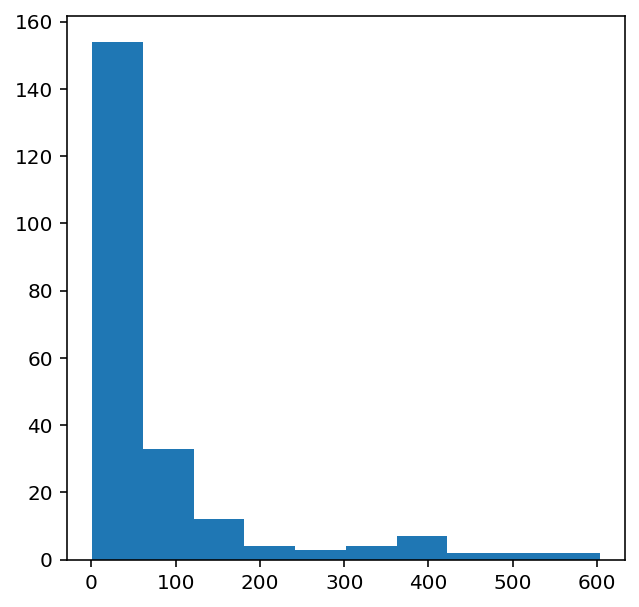

In [31]:
from collections import Counter

#computing frequency of each note
freq = dict(Counter(notes_))

#library for visualiation
import matplotlib.pyplot as plt

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

In [32]:
note_dict = dict()
for i, note in enumerate(pitches):
  note_dict[note] = i

sequence_length = 50

num_training = number_notes - sequence_length

input_notes = np.zeros((num_training, sequence_length, vocab_length))
output_notes = np.zeros((num_training, vocab_length))

for i in range(0, num_training):
    # Here, i is the training example, j is the note in the sequence for a specific training example
    input_sequence = notes_[i: i+sequence_length]
    output_note = notes_[i+sequence_length]
    for j, note in enumerate(input_sequence):
        input_notes[i][j][note_dict[note]] = 1
    output_notes[i][note_dict[output_note]] = 1

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Input, LSTM, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(sequence_length, vocab_length)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(vocab_length))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['acc'])
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
cp_callback = ModelCheckpoint(
    save_weights_only=True,
    save_freq='epoch',
    filepath,
    period=10)


history = model.fit(input_notes, output_notes, batch_size=128, epochs=100,callbacks=[cp_callback])

Epoch 1/100
126/126 [==============================] - 55s 407ms/step - loss: 4.7116 - acc: 0.0331
Epoch 2/100
126/126 [==============================] - 43s 339ms/step - loss: 4.0873 - acc: 0.0712
Epoch 3/100
126/126 [==============================] - 43s 339ms/step - loss: 3.7666 - acc: 0.1086
Epoch 4/100
126/126 [==============================] - 43s 345ms/step - loss: 3.5008 - acc: 0.1358
Epoch 5/100
126/126 [==============================] - 43s 339ms/step - loss: 3.3055 - acc: 0.1603
Epoch 6/100
126/126 [==============================] - 43s 344ms/step - loss: 3.1673 - acc: 0.1770
Epoch 7/100
126/126 [==============================] - 43s 340ms/step - loss: 3.0574 - acc: 0.1912
Epoch 8/100
126/126 [==============================] - 43s 342ms/step - loss: 2.9530 - acc: 0.2066
Epoch 9/100
126/126 [==============================] - 43s 342ms/step - loss: 2.8909 - acc: 0.2196
Epoch 10/100
126/126 [==============================] - 43s 341ms/step - loss: 2.7972 - acc: 0.2271
Epoch 11/

In [ ]:
model.save_weights("LSTM_SCHUBERT.h5")

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
# generating music 

backward_dict = dict()
for note in note_dict.keys():
  index = note_dict[note]
  backward_dict[index] = note

for i in range(0, 100):
  newNote = model.predict(start_sequence, verbose=0)
  # Get the position with the highest probability
  index = np.argmax(newNote)
  encoded_note = np.zeros((vocab_length))
  encoded_note[index] = 1
  output.append(encoded_note)
  sequence = start_sequence[0][1:]
  start_sequence = np.concatenate((sequence, encoded_note.reshape(1, vocab_length)))
  start_sequence = start_sequence.reshape(1, sequence_length, vocab_length)
